# Detecció i Classificació d'Expressions Facials
Aquest codi entrena un model de Deep Learning (CNN) amb el dataset FER-2013 per classificar emocions facials a partir d'imatges. Inclou:
- Preparació i augment de les dades
- Construcció i entrenament del model amb class weights
- Avaluació amb gràfics d'accuracy i loss
- Anàlisi amb matriu de confusió i informe de classificació

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt


In [ ]:
# Fixar la llavor per reproduïbilitat

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(42)


## 1. Carreguem el dataset

In [ ]:
import kagglehub

# Descarreguem el dataset FER-2013 i definim les rutes
path = kagglehub.dataset_download("msambare/fer2013")
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")

## 2. Preprocessament de les dades




In [ ]:

# Normalització i separació per validació (20%)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Generador d’imatges per a entrenament
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    subset='training',
    seed=42,
    shuffle=True
)

# Generador d’imatges per a validació
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    subset='validation',
    seed=42,
    shuffle=False
)

# Comprovem les categories
print("Categories d'emocions:", train_generator.class_indices)


Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
Categories d'emocions: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## Visualitzem les dades

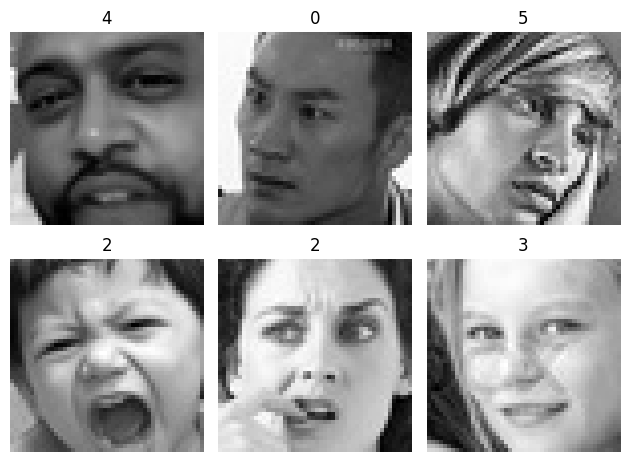

In [ ]:
images, labels = next(train_generator)
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(np.argmax(labels[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()


angry: 3196 imatges
disgust: 349 imatges
fear: 3278 imatges
happy: 5772 imatges
neutral: 3972 imatges
sad: 3864 imatges
surprise: 2537 imatges


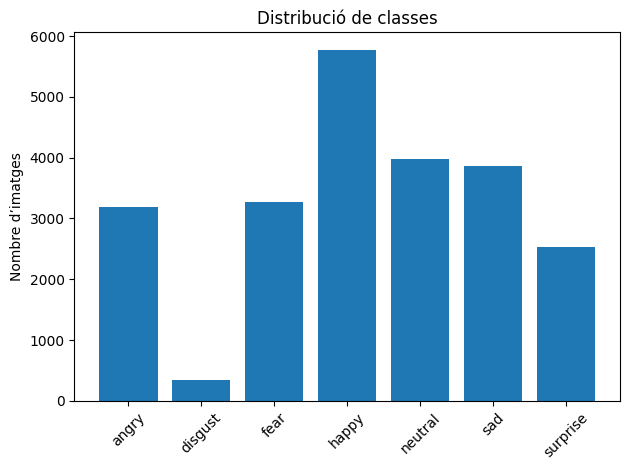

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Comptar quantes imatges hi ha de cada classe
labels, counts = np.unique(train_generator.classes, return_counts=True)

# Obtenir els noms de les classes
class_names = list(train_generator.class_indices.keys())

# Mostrar els resultats
for label, count in zip(class_names, counts):
    print(f"{label}: {count} imatges")

# Gràfic de barres
plt.bar(class_names, counts)
plt.xticks(rotation=45)
plt.title("Distribució de classes")
plt.ylabel("Nombre d’imatges")
plt.tight_layout()
plt.show()


## 3. Construcció del model CNN

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),


    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])


# Compilar el model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resum del model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619,783 (2.36 MB)

 Trainable params: 619,399 (2.36 MB)

 Non-trainable params: 384 (1.50 KB)

## 4. Entrenament del model

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calcular els pesos de classe per compensar el desequilibri del dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping per evitar l'overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenament del model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.2039 - loss: 2.2816 - val_accuracy: 0.2088 - val_loss: 1.9304
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.2947 - loss: 1.7648 - val_accuracy: 0.2430 - val_loss: 1.8546
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.3165 - loss: 1.6993 - val_accuracy: 0.3554 - val_loss: 1.6264
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.3544 - loss: 1.5985 - val_accuracy: 0.4022 - val_loss: 1.5678
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3815 - loss: 1.5607 - val_accuracy: 0.4015 - val_loss: 1.5295
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.4099 - loss: 1.4621 - val_accuracy: 0.4071 - val_loss: 1.4836
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.4323 - loss: 1.3872 - val_accuracy: 0.4434 - val_loss: 1.4303
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.4563 - loss: 1.3351 - 

In [ ]:
model.evaluate(test_generator)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5324 - loss: 1.3273


[1.2289657592773438, 0.5733240246772766]

## 5. Avaluació i visualització dels resultats

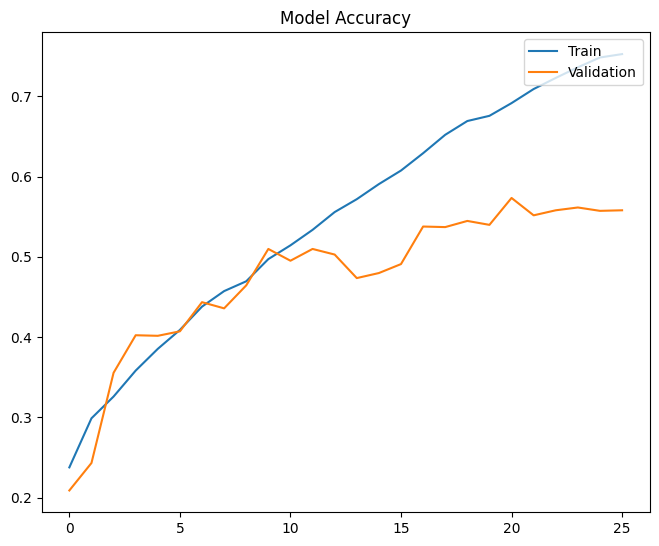

In [ ]:
# Gràfic de l'evolució de l'accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

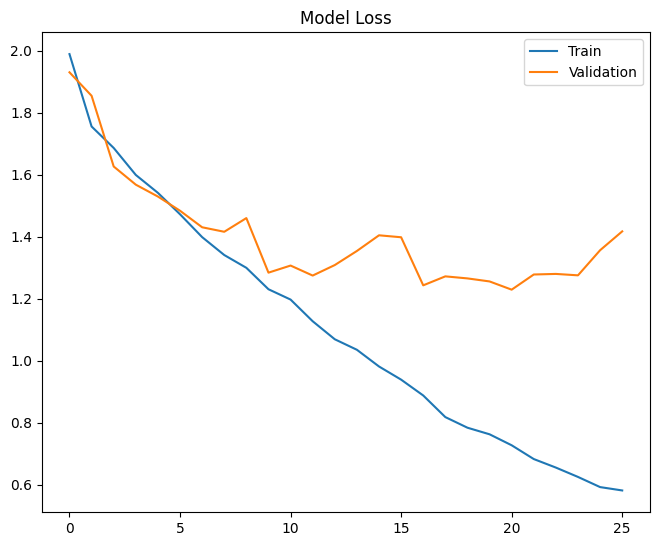

In [ ]:
# Gràfic de l'evolució de la loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

##7. Matriu de confusió i prediccions

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


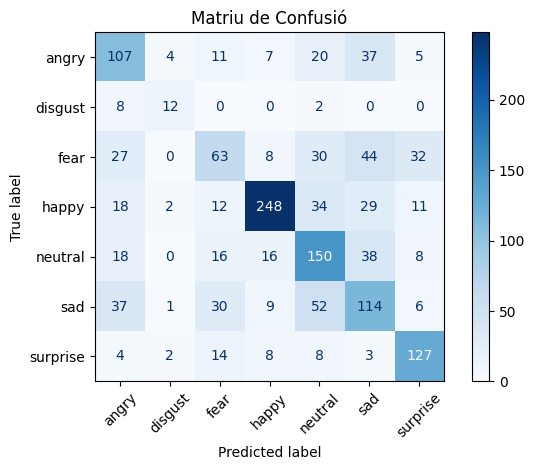

Informe de classificació:

              precision    recall  f1-score   support

       angry       0.49      0.56      0.52       191
     disgust       0.57      0.55      0.56        22
        fear       0.43      0.31      0.36       204
       happy       0.84      0.70      0.76       354
     neutral       0.51      0.61      0.55       246
         sad       0.43      0.46      0.44       249
    surprise       0.67      0.77      0.72       166

    accuracy                           0.57      1432
   macro avg       0.56      0.56      0.56      1432
weighted avg       0.58      0.57      0.57      1432



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

# Obtenim les prediccions del model sobre el conjunt de validació
y_pred_probs = model.predict(test_generator)  # Prediccions en probabilitats
y_pred = np.argmax(y_pred_probs, axis=1)     # Classes amb més probabilitat

# Labels reals
y_true = test_generator.classes

# Noms de les emocions (ex: ['angry', 'happy', ...])
class_names = list(test_generator.class_indices.keys())

# Matriu de confusió
cm = confusion_matrix(y_true, y_pred)

# Visualització de la matriu
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Matriu de Confusió")
plt.tight_layout()
plt.show()

# Informe complet
print("Informe de classificació:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


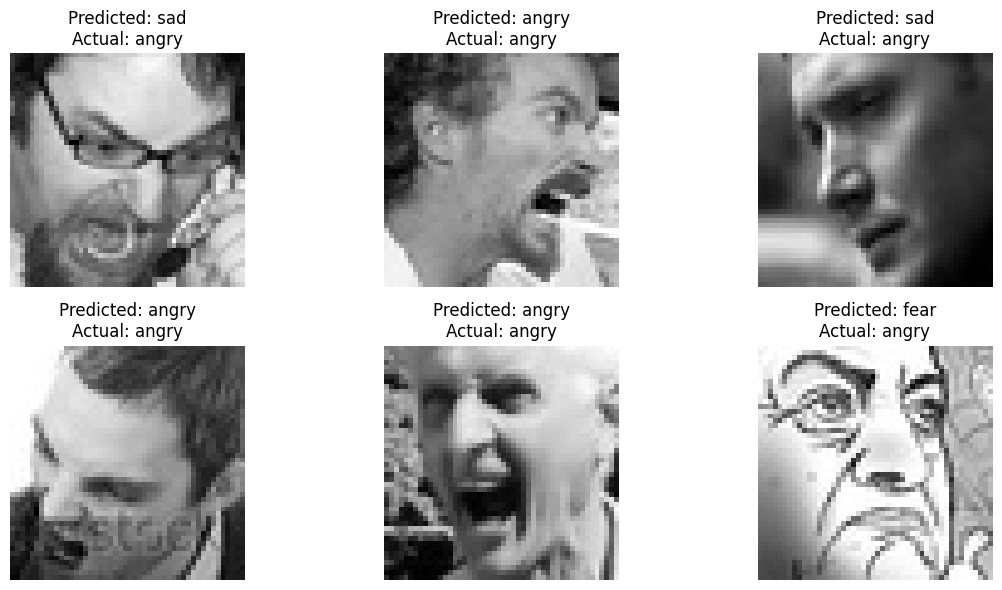

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

test_generator.reset()

# Obté un batch d’imatges
images, labels = next(test_generator)

# Noms de les classes
class_names = list(test_generator.class_indices.keys())

# Mostra les primeres 6 imatges
N = 6
plt.figure(figsize=(12, 6))

for i in range(N):
    img = images[i]
    true_label = np.argmax(labels[i])

    pred_prob = model.predict(img[np.newaxis, ...], verbose=0)
    pred_label = np.argmax(pred_prob)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {class_names[pred_label]}\nActual: {class_names[true_label]}")

plt.tight_layout()
plt.show()
